In [0]:
## Use case 4 — Customer Segmentation (KMeans)

In [0]:
!pip install openpyxl

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%restart_python

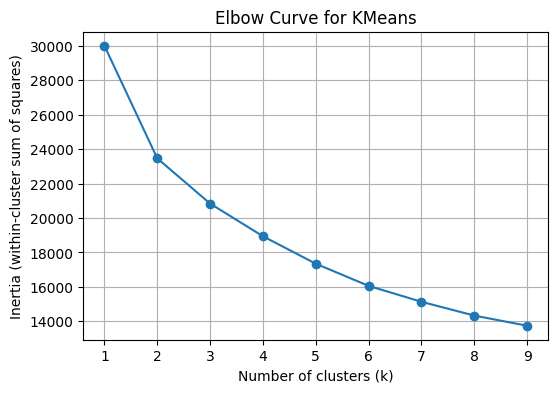

Segment counts:
 segment
2    2219
1    2029
0     752
Name: count, dtype: int64


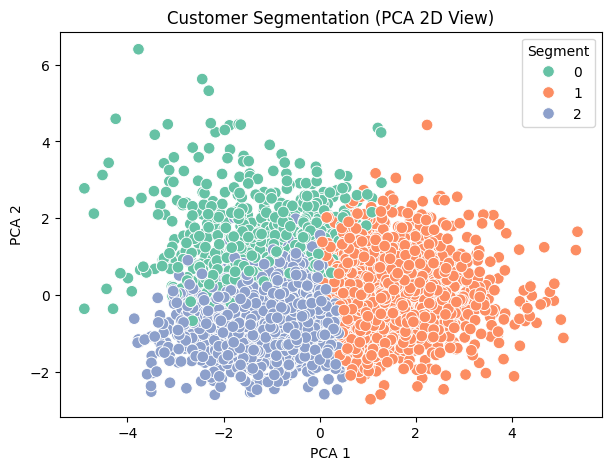

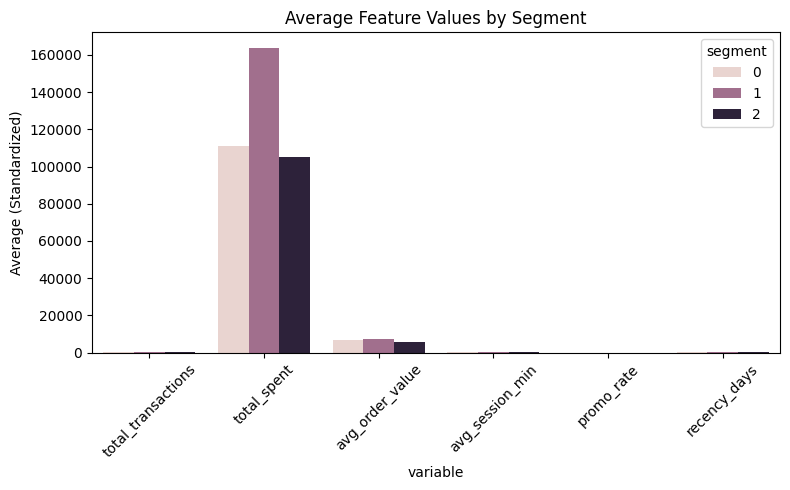

In [0]:
#UseCase4_segmentation_with_graphs.py

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ============================
# 1️⃣ Load Data
# ============================
df = pd.read_excel("/Volumes/capston_project-priya_saini(24mbmb34)/default/capston_project-priya_saini(24mbmb34)/ecommerce_data.xlsx", parse_dates=["purchase_date"])

# ============================
# 2️⃣ Customer Aggregation
# ============================
cust = df.groupby("customer_id").agg(
    total_transactions=("transaction_id", "count"),
    total_spent=("total_spent", "sum"),
    avg_order_value=("total_spent", "mean"),
    avg_session_min=("session_duration_min", "mean"),
    promo_rate=("promo_used", "mean"),
    last_purchase=("purchase_date", "max")
).reset_index()

# Add recency feature (days since last purchase)
dataset_end = df["purchase_date"].max()
cust["recency_days"] = (dataset_end - cust["last_purchase"]).dt.days

# ============================
# 3️⃣ Feature Scaling
# ============================
features = ["total_transactions", "total_spent", "avg_order_value", "avg_session_min", "promo_rate", "recency_days"]
X = cust[features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================
# 4️⃣ Elbow Method to choose K
# ============================
inertia = []
K_range = range(1, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Curve for KMeans")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.grid(True)
plt.show()

# ============================
# 5️⃣ Final KMeans (k=3)
# ============================
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
cust["segment"] = kmeans.fit_predict(X_scaled)

print("Segment counts:\n", cust["segment"].value_counts())

# ============================
# 6️⃣ PCA for 2D Visualization
# ============================
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)
cust["pca1"] = pca_data[:, 0]
cust["pca2"] = pca_data[:, 1]

plt.figure(figsize=(7,5))
sns.scatterplot(data=cust, x="pca1", y="pca2", hue="segment", palette="Set2", s=70)
plt.title("Customer Segmentation (PCA 2D View)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Segment")
plt.show()

# ============================
# 7️⃣ Segment Profiles
# ============================
seg_profile = cust.groupby("segment")[features].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=seg_profile.melt(id_vars="segment"), x="variable", y="value", hue="segment")
plt.title("Average Feature Values by Segment")
plt.xticks(rotation=45)
plt.ylabel("Average (Standardized)")
plt.tight_layout()
plt.show()
